In [1]:
conda init

no change     /Users/aesthetic/opt/anaconda3/condabin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda-env
no change     /Users/aesthetic/opt/anaconda3/bin/activate
no change     /Users/aesthetic/opt/anaconda3/bin/deactivate
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.sh
no change     /Users/aesthetic/opt/anaconda3/etc/fish/conf.d/conda.fish
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/Conda.psm1
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/conda-hook.ps1
no change     /Users/aesthetic/opt/anaconda3/lib/python3.8/site-packages/xontrib/conda.xsh
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.csh
no change     /Users/aesthetic/.bash_profile
No action taken.

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install alpha_vantage pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from alpha_vantage.techindicators import TechIndicators
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt 
import sys
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


import numpy as np



In [4]:
# Obtaining stock data from alpha vantage 
sym='AAPL'




ticker_list=['MS', 'BT-A.L', 'TSLA', 'PFE' ]
# 'BT-A.L', 'TSLA', 'PFE'
column_names=['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume', 
               '7. dividend amount', '8. split coefficient', 'Ticker']
#obtains stock data from the previous day date to 2018-11-29


def stock_data(sym):
    ts = TimeSeries(key='SUXOFAIGXM6HEP9Y', output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol=sym, outputsize='full')
    data_date_changed = data[:'2019-01-01']
    data_date_changed['Ticker']= sym
    return data_date_changed


data_dated = pd.DataFrame(columns = column_names)


for ticker in ticker_list:
    data_dated = data_dated.append(stock_data(ticker), sort=False)


<ipython-input-4-50d4edb1b606>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_date_changed['Ticker']= sym


# Identify Anomalies

In [5]:
print('The shape of our data is:', data_dated.shape)

The shape of our data is: (2131, 9)


In [6]:
data_dated.isna().any()

1. open                 False
2. high                 False
3. low                  False
4. close                False
5. adjusted close       False
6. volume               False
7. dividend amount      False
8. split coefficient    False
Ticker                  False
dtype: bool

In [7]:
data_dated.head()

1. open  2. high   3. low  4. close  5. adjusted close  6. volume  \
2021-02-10    74.60   74.865  73.5500     74.33              74.33  7180859.0   
2021-02-09    73.90   74.680  73.3700     74.24              74.24  7323686.0   
2021-02-08    73.64   74.290  73.4000     74.23              74.23  9018095.0   
2021-02-05    73.10   73.715  72.5503     73.22              73.22  8832176.0   
2021-02-04    70.93   72.320  70.7670     72.29              72.29  8889354.0   

            7. dividend amount  8. split coefficient Ticker  
2021-02-10                 0.0                   1.0     MS  
2021-02-09                 0.0                   1.0     MS  
2021-02-08                 0.0                   1.0     MS  
2021-02-05                 0.0                   1.0     MS  
2021-02-04                 0.0                   1.0     MS

In [8]:

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

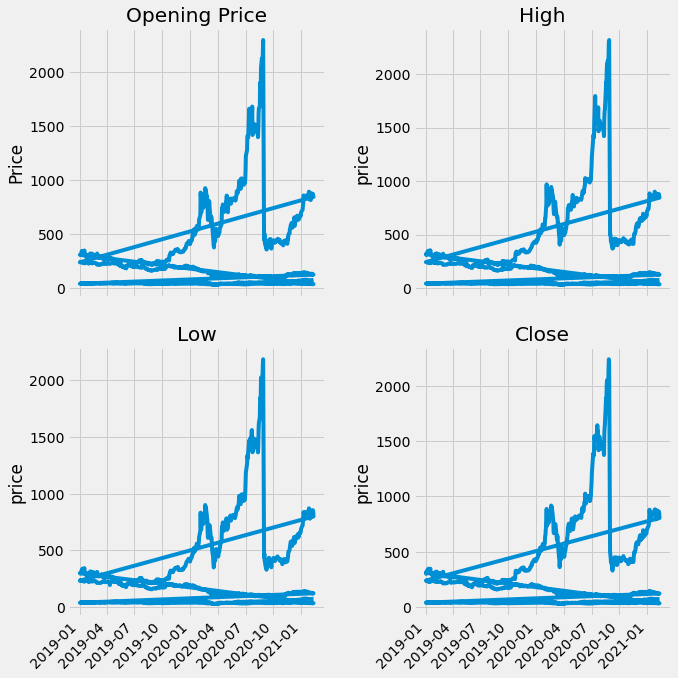

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# opening price
ax1.plot(data_dated.index, data_dated['1. open'])
ax1.set_xlabel(''); ax1.set_ylabel('Price'); ax1.set_title('Opening Price')


ax2.plot(data_dated.index, data_dated['2. high'])
ax2.set_xlabel(''); ax2.set_ylabel('price'); ax2.set_title('High')


ax3.plot(data_dated.index, data_dated['3. low'])
ax3.set_xlabel(''); ax3.set_ylabel('price'); ax3.set_title('Low')

ax4.plot(data_dated.index, data_dated['4. close'])
ax4.set_xlabel(''); ax4.set_ylabel('price'); ax4.set_title('Close')


plt.tight_layout(pad=2)


In [10]:
data_dated[data_dated.duplicated()]

Empty DataFrame
Columns: [1. open, 2. high, 3. low, 4. close, 5. adjusted close, 6. volume, 7. dividend amount, 8. split coefficient, Ticker]
Index: []

One Hot Encoding 

# data_dated.tail()

In [11]:
data_dated['date']= data_dated.index

In [12]:
data_dated.sort_index(inplace=True)
data_dated.sort_values(by = ['Ticker','date'], inplace = True)


data_dated['change_in_price']= data_dated['4. close'].diff()

In [13]:
mask = data_dated['Ticker'] != data_dated['Ticker'].shift(1)

data_dated['change_in_price']= np.where(mask==True, np.nan, data_dated['change_in_price'])

data_dated[data_dated.isna().any(axis=1)]

1. open  2. high  3. low  4. close  5. adjusted close   6. volume  \
2019-01-02   237.00   242.20  233.25    240.00         220.802700  20278421.0   
2019-01-02    39.02    40.72   38.76     40.40          37.935801  10648013.0   
2019-01-02    43.12    43.50   42.64     43.25          37.587547  25076212.0   
2019-01-02   306.10   315.13  298.80    310.12          62.024000  11658600.0   

            7. dividend amount  8. split coefficient  Ticker       date  \
2019-01-02                 0.0                   1.0  BT-A.L 2019-01-02   
2019-01-02                 0.0                   1.0      MS 2019-01-02   
2019-01-02                 0.0                   1.0     PFE 2019-01-02   
2019-01-02                 0.0                   1.0    TSLA 2019-01-02   

            change_in_price  
2019-01-02              NaN  
2019-01-02              NaN  
2019-01-02              NaN  
2019-01-02              NaN

In [14]:
data_dated.reset_index(inplace=True)

In [15]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = data_dated[['Ticker','change_in_price']].copy(), data_dated[['Ticker','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
data_dated['down_days'] = down_df['change_in_price']
data_dated['up_days'] = up_df['change_in_price']
data_dated['RSI'] = relative_strength_index

# Display the head.
data_dated.head(30)

index  1. open  2. high    3. low  4. close  5. adjusted close  \
0  2019-01-02   237.00   242.20  233.2500    240.00           220.8027   
1  2019-01-03   240.10   242.60  237.5500    240.10           220.8947   
2  2019-01-04   241.00   241.90  236.4500    237.35           218.3646   
3  2019-01-07   239.95   242.00  237.0660    237.95           218.9167   
4  2019-01-08   237.75   238.90  229.4000    231.00           212.5226   
5  2019-01-09   232.30   234.85  230.5500    232.50           213.9026   
6  2019-01-10   232.70   234.70  231.8500    233.55           214.8686   
7  2019-01-11   233.75   236.35  232.5000    233.05           214.4086   
8  2019-01-14   232.85   233.15  228.0500    228.60           210.3146   
9  2019-01-15   231.65   232.25  229.1000    229.95           211.5566   
10 2019-01-16   231.00   232.20  227.8000    227.80           209.5785   
11 2019-01-17   226.90   232.25  225.2840    231.85           213.3046   
12 2019-01-18   232.15   239.70  231.0500    238.90           219.7906   
13 2019-01-21   238.10   240.75  235.4500    238.00           218.9627   
14 2019-01-22   238.05   241.40  236.4500    238.00           218.9627   
15 2019-01-23   236.85   240.40  233.3000    237.90           218.8707   
16 2019-01-24   237.95   238.85  234.7500    236.25           217.3527   
17 2019-01-25   236.40   237.40  233.4000    236.40           217.4907   
18 2019-01-28   235.35   240.35  234.0500    236.00           217.1227   
19 2019-01-29   236.15   239.35  234.3000    234.30           215.5587   
20 2019-01-30   235.00   236.35  231.2500    234.00           215.2826   
21 2019-01-31   224.90   238.00  221.0000    232.40           213.8106   
22 2019-02-01   230.35   233.01  228.2000    230.00           211.6026   
23 2019-02-04   230.95   233.10  229.7500    230.75           212.2926   
24 2019-02-05   230.65   234.10  230.3611    233.95           215.2366   
25 2019-02-06   233.85   237.97  230.8000    232.45           213.8566   
26 2019-02-07   233.45   233.80  227.2000    228.85           210.5446   
27 2019-02-08   228.30   230.35  226.5090    227.95           209.7166   
28 2019-02-11   229.05   231.75  228.1500    229.45           211.0966   
29 2019-02-12   230.05   232.90  227.3000    227.80           209.5785   

     6. volume  7. dividend amount  8. split coefficient  Ticker       date  \
0   20278421.0                 0.0                   1.0  BT-A.L 2019-01-02   
1   13975097.0                 0.0                   1.0  BT-A.L 2019-01-03   
2   19484073.0                 0.0                   1.0  BT-A.L 2019-01-04   
3   15507525.0                 0.0                   1.0  BT-A.L 2019-01-07   
4   26557234.0                 0.0                   1.0  BT-A.L 2019-01-08   
5   25148123.0                 0.0                   1.0  BT-A.L 2019-01-09   
6   17643904.0                 0.0                   1.0  BT-A.L 2019-01-10   
7   46248643.0                 0.0                   1.0  BT-A.L 2019-01-11   
8   50697635.0                 0.0                   1.0  BT-A.L 2019-01-14   
9   17775775.0                 0.0                   1.0  BT-A.L 2019-01-15   
10  18332771.0                 0.0                   1.0  BT-A.L 2019-01-16   
11  48010921.0                 0.0                   1.0  BT-A.L 2019-01-17   
12  26460469.0                 0.0                   1.0  BT-A.L 2019-01-18   
13  14523400.0                 0.0                   1.0  BT-A.L 2019-01-21   
14  18538398.0                 0.0                   1.0  BT-A.L 2019-01-22   
15  16839418.0                 0.0                   1.0  BT-A.L 2019-01-23   
16  16914074.0                 0.0                   1.0  BT-A.L 2019-01-24   
17  21481208.0                 0.0                   1.0  BT-A.L 2019-01-25   
18  16641931.0                 0.0                   1.0  BT-A.L 2019-01-28   
19  19319500.0                 0.0                   1.0  BT-A.L 2019-01-29   
20  21472302.0                 0.0                   1

In [16]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = data_dated[['Ticker','3. low']].copy(), data_dated[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((data_dated['4. close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
data_dated['low_14'] = low_14
data_dated['high_14'] = high_14
data_dated['k_percent'] = k_percent

# Display the head.
data_dated.head(5)

index  1. open  2. high   3. low  4. close  5. adjusted close  \
0 2019-01-02   237.00    242.2  233.250    240.00           220.8027   
1 2019-01-03   240.10    242.6  237.550    240.10           220.8947   
2 2019-01-04   241.00    241.9  236.450    237.35           218.3646   
3 2019-01-07   239.95    242.0  237.066    237.95           218.9167   
4 2019-01-08   237.75    238.9  229.400    231.00           212.5226   

    6. volume  7. dividend amount  8. split coefficient  Ticker       date  \
0  20278421.0                 0.0                   1.0  BT-A.L 2019-01-02   
1  13975097.0                 0.0                   1.0  BT-A.L 2019-01-03   
2  19484073.0                 0.0                   1.0  BT-A.L 2019-01-04   
3  15507525.0                 0.0                   1.0  BT-A.L 2019-01-07   
4  26557234.0                 0.0                   1.0  BT-A.L 2019-01-08   

   change_in_price  down_days  up_days         RSI  low_14  high_14  k_percent  
0              NaN        NaN      NaN         NaN     NaN      NaN        NaN  
1             0.10       0.00      0.1  100.000000     NaN      NaN        NaN  
2            -2.75       2.75      0.0    3.055229     NaN      NaN        NaN  
3             0.60       0.00      0.6   22.073676     NaN      NaN        NaN  
4            -6.95       6.95      0.0    6.094339     NaN      NaN        NaN

In [17]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = data_dated[['Ticker','3. low']].copy(), data_dated[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - data_dated['4. close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
data_dated['r_percent'] = r_percent

# Display the head.
data_dated.head(5)

index  1. open  2. high   3. low  4. close  5. adjusted close  \
0 2019-01-02   237.00    242.2  233.250    240.00           220.8027   
1 2019-01-03   240.10    242.6  237.550    240.10           220.8947   
2 2019-01-04   241.00    241.9  236.450    237.35           218.3646   
3 2019-01-07   239.95    242.0  237.066    237.95           218.9167   
4 2019-01-08   237.75    238.9  229.400    231.00           212.5226   

    6. volume  7. dividend amount  8. split coefficient  Ticker       date  \
0  20278421.0                 0.0                   1.0  BT-A.L 2019-01-02   
1  13975097.0                 0.0                   1.0  BT-A.L 2019-01-03   
2  19484073.0                 0.0                   1.0  BT-A.L 2019-01-04   
3  15507525.0                 0.0                   1.0  BT-A.L 2019-01-07   
4  26557234.0                 0.0                   1.0  BT-A.L 2019-01-08   

   change_in_price  down_days  up_days         RSI  low_14  high_14  \
0              NaN        NaN      NaN         NaN     NaN      NaN   
1             0.10       0.00      0.1  100.000000     NaN      NaN   
2            -2.75       2.75      0.0    3.055229     NaN      NaN   
3             0.60       0.00      0.6   22.073676     NaN      NaN   
4            -6.95       6.95      0.0    6.094339     NaN      NaN   

   k_percent  r_percent  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [18]:
# Calculate the MACD
ema_26 = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
data_dated['MACD'] = macd
data_dated['MACD_EMA'] = ema_9_macd

# Print the head.
data_dated.head(5)

index  1. open  2. high   3. low  4. close  5. adjusted close  \
0 2019-01-02   237.00    242.2  233.250    240.00           220.8027   
1 2019-01-03   240.10    242.6  237.550    240.10           220.8947   
2 2019-01-04   241.00    241.9  236.450    237.35           218.3646   
3 2019-01-07   239.95    242.0  237.066    237.95           218.9167   
4 2019-01-08   237.75    238.9  229.400    231.00           212.5226   

    6. volume  7. dividend amount  8. split coefficient  Ticker  ...  \
0  20278421.0                 0.0                   1.0  BT-A.L  ...   
1  13975097.0                 0.0                   1.0  BT-A.L  ...   
2  19484073.0                 0.0                   1.0  BT-A.L  ...   
3  15507525.0                 0.0                   1.0  BT-A.L  ...   
4  26557234.0                 0.0                   1.0  BT-A.L  ...   

  change_in_price  down_days  up_days         RSI  low_14  high_14  k_percent  \
0             NaN        NaN      NaN         NaN     NaN      NaN        NaN   
1            0.10       0.00      0.1  100.000000     NaN      NaN        NaN   
2           -2.75       2.75      0.0    3.055229     NaN      NaN        NaN   
3            0.60       0.00      0.6   22.073676     NaN      NaN        NaN   
4           -6.95       6.95      0.0    6.094339     NaN      NaN        NaN   

   r_percent      MACD  MACD_EMA  
0        NaN  0.000000  0.000000  
1        NaN  0.002244  0.001246  
2        NaN -0.082419 -0.033042  
3        NaN -0.097242 -0.054790  
4        NaN -0.379806 -0.151475  

[5 rows x 21 columns]

In [19]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
data_dated['Price_Rate_Of_Change'] = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
data_dated.head(5)

index  1. open  2. high   3. low  4. close  5. adjusted close  \
0 2019-01-02   237.00    242.2  233.250    240.00           220.8027   
1 2019-01-03   240.10    242.6  237.550    240.10           220.8947   
2 2019-01-04   241.00    241.9  236.450    237.35           218.3646   
3 2019-01-07   239.95    242.0  237.066    237.95           218.9167   
4 2019-01-08   237.75    238.9  229.400    231.00           212.5226   

    6. volume  7. dividend amount  8. split coefficient  Ticker  ...  \
0  20278421.0                 0.0                   1.0  BT-A.L  ...   
1  13975097.0                 0.0                   1.0  BT-A.L  ...   
2  19484073.0                 0.0                   1.0  BT-A.L  ...   
3  15507525.0                 0.0                   1.0  BT-A.L  ...   
4  26557234.0                 0.0                   1.0  BT-A.L  ...   

  down_days  up_days         RSI  low_14  high_14  k_percent  r_percent  \
0       NaN      NaN         NaN     NaN      NaN        NaN        NaN   
1      0.00      0.1  100.000000     NaN      NaN        NaN        NaN   
2      2.75      0.0    3.055229     NaN      NaN        NaN        NaN   
3      0.00      0.6   22.073676     NaN      NaN        NaN        NaN   
4      6.95      0.0    6.094339     NaN      NaN        NaN        NaN   

       MACD  MACD_EMA  Price_Rate_Of_Change  
0  0.000000  0.000000                   NaN  
1  0.002244  0.001246                   NaN  
2 -0.082419 -0.033042                   NaN  
3 -0.097242 -0.054790                   NaN  
4 -0.379806 -0.151475                   NaN  

[5 rows x 22 columns]

In [20]:
def obv(group):

    # Grab the volume and close column.
    volume = group['6. volume']
    change = group['4. close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = data_dated.groupby('Ticker').apply(obv)

# add to the data frame, but drop the old index, before adding it.
data_dated['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
data_dated.head(5)

index  1. open  2. high   3. low  4. close  5. adjusted close  \
0 2019-01-02   237.00    242.2  233.250    240.00           220.8027   
1 2019-01-03   240.10    242.6  237.550    240.10           220.8947   
2 2019-01-04   241.00    241.9  236.450    237.35           218.3646   
3 2019-01-07   239.95    242.0  237.066    237.95           218.9167   
4 2019-01-08   237.75    238.9  229.400    231.00           212.5226   

    6. volume  7. dividend amount  8. split coefficient  Ticker  ... up_days  \
0  20278421.0                 0.0                   1.0  BT-A.L  ...     NaN   
1  13975097.0                 0.0                   1.0  BT-A.L  ...     0.1   
2  19484073.0                 0.0                   1.0  BT-A.L  ...     0.0   
3  15507525.0                 0.0                   1.0  BT-A.L  ...     0.6   
4  26557234.0                 0.0                   1.0  BT-A.L  ...     0.0   

          RSI  low_14  high_14  k_percent  r_percent      MACD  MACD_EMA  \
0         NaN     NaN      NaN        NaN        NaN  0.000000  0.000000   
1  100.000000     NaN      NaN        NaN        NaN  0.002244  0.001246   
2    3.055229     NaN      NaN        NaN        NaN -0.082419 -0.033042   
3   22.073676     NaN      NaN        NaN        NaN -0.097242 -0.054790   
4    6.094339     NaN      NaN        NaN        NaN -0.379806 -0.151475   

   Price_Rate_Of_Change  On Balance Volume  
0                   NaN                0.0  
1                   NaN         13975097.0  
2                   NaN         -5508976.0  
3                   NaN          9998549.0  
4                   NaN        -16558685.0  

[5 rows x 23 columns]

In [21]:
# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = data_dated.groupby('Ticker')['4. close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
data_dated['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
data_dated.loc[data_dated['Prediction'] == 0.0] = 1.0

# print the head
data_dated.head(5)

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

index  1. open  2. high   3. low  4. close  \
0  2019-01-02 00:00:00   237.00    242.2  233.250    240.00   
1  2019-01-03 00:00:00   240.10    242.6  237.550    240.10   
2  2019-01-04 00:00:00   241.00    241.9  236.450    237.35   
3  2019-01-07 00:00:00   239.95    242.0  237.066    237.95   
4  2019-01-08 00:00:00   237.75    238.9  229.400    231.00   

   5. adjusted close   6. volume  7. dividend amount  8. split coefficient  \
0           220.8027  20278421.0                 0.0                   1.0   
1           220.8947  13975097.0                 0.0                   1.0   
2           218.3646  19484073.0                 0.0                   1.0   
3           218.9167  15507525.0                 0.0                   1.0   
4           212.5226  26557234.0                 0.0                   1.0   

   Ticker  ...         RSI  low_14  high_14  k_percent  r_percent      MACD  \
0  BT-A.L  ...         NaN     NaN      NaN        NaN        NaN  0.000000   
1  BT-A.L  ...  100.000000     NaN      NaN        NaN        NaN  0.002244   
2  BT-A.L  ...    3.055229     NaN      NaN        NaN        NaN -0.082419   
3  BT-A.L  ...   22.073676     NaN      NaN        NaN        NaN -0.097242   
4  BT-A.L  ...    6.094339     NaN      NaN        NaN        NaN -0.379806   

   MACD_EMA  Price_Rate_Of_Change  On Balance Volume  Prediction  
0  0.000000                   NaN                0.0         NaN  
1  0.001246                   NaN         13975097.0         1.0  
2 -0.033042                   NaN         -5508976.0        -1.0  
3 -0.054790                   NaN          9998549.0         1.0  
4 -0.151475                   NaN        -16558685.0        -1.0  

[5 rows x 24 columns]

In [22]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(data_dated.shape[0], data_dated.shape[1]))

# Any row that has a `NaN` value will be dropped.
data_dated = data_dated.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(data_dated.shape[0], data_dated.shape[1]))

# Print the head.
data_dated.head()

Before NaN Drop we have 2131 rows and 24 columns
After NaN Drop we have 2079 rows and 24 columns


index  1. open  2. high  3. low  4. close  \
13  2019-01-21 00:00:00   238.10   240.75  235.45    238.00   
14                    1     1.00     1.00    1.00      1.00   
15  2019-01-23 00:00:00   236.85   240.40  233.30    237.90   
16  2019-01-24 00:00:00   237.95   238.85  234.75    236.25   
17  2019-01-25 00:00:00   236.40   237.40  233.40    236.40   

    5. adjusted close   6. volume  7. dividend amount  8. split coefficient  \
13           218.9627  14523400.0                 0.0                   1.0   
14             1.0000         1.0                 1.0                   1.0   
15           218.8707  16839418.0                 0.0                   1.0   
16           217.3527  16914074.0                 0.0                   1.0   
17           217.4907  21481208.0                 0.0                   1.0   

    Ticker  ...        RSI   low_14  high_14  k_percent  r_percent      MACD  \
13  BT-A.L  ...  60.390476  225.284    242.6  73.434973 -26.565027 -0.039403   
14       1  ...   1.000000    1.000      1.0   1.000000   1.000000  1.000000   
15  BT-A.L  ...  59.949808  225.284    242.0  75.472601 -24.527399  0.382881   
16  BT-A.L  ...  52.637268  225.284    242.0  65.601819 -34.398181  0.411211   
17  BT-A.L  ...  53.235612  225.284    241.4  68.974932 -31.025068  0.437317   

    MACD_EMA  Price_Rate_Of_Change  On Balance Volume  Prediction  
13 -0.489356              0.030303        -11321942.0        -1.0  
14  1.000000              1.000000                1.0         1.0  
15 -0.195440              0.018626        -28161360.0        -1.0  
16 -0.071315              0.013731        -45075434.0        -1.0  
17  0.032278              0.034121        -23594226.0         1.0  

[5 rows x 24 columns]

In [23]:
# Grab our X & Y Columns.
X_Cols = data_dated[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = data_dated['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [24]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  70.76923076923077


In [25]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

precision    recall  f1-score     support
Down Day       0.712598  0.696154  0.704280  260.000000
Up Day         0.703008  0.719231  0.711027  260.000000
accuracy       0.707692  0.707692  0.707692    0.707692
macro avg      0.707803  0.707692  0.707653  520.000000
weighted avg   0.707803  0.707692  0.707653  520.000000

Accuracy: 0.7076923076923077
Percision: 0.7030075187969925
Recall: 0.7192307692307692
Specificity: 0.6961538461538461


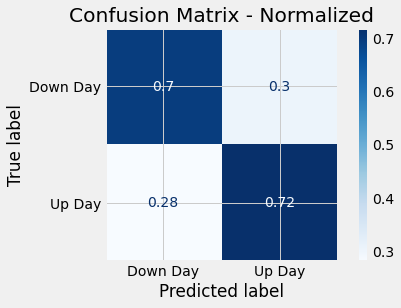

In [26]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()